In [2]:
import os, torch

print("Running initial Google Colab checks...")
print("For missing files check https://github.com/pr/briar, but feel free to use your own")

OPEN_AI_API_KEY = None

if OPEN_AI_API_KEY is None:
    raise Exception("You need an Open AI API key.")

if not torch.cuda.is_available():
    raise Exception("Change the runtime type to something with a GPU!")
else:
    print("Found GPU...")

if not os.path.exists("/content/initial_decision_point.png"):
    raise Exception("Please upload an initial_decision_point.png image")
else:
    print("initial_decision_point.png found...")

if not os.path.exists("/content/bad_nba_training_dataset.zip"):
    raise Exception("Please upload bad_nba_training_dataset.zip or a better alternative")
else:
    print("bad_nba_training_dataset.zip found...")

if not os.path.exists("/content/briar_chat_api.prompt"):
    raise Exception("Please upload briar_chat_api.prompt")
else:
    print("briar_chat_api.prompt found...")

print("Done!")

Running initial Google Colab checks...
For missing files check https://github.com/pr/briar, but feel free to use your own
Found GPU...
initial_decision_point.png found...
bad_nba_training_dataset.zip found...
briar_chat_api.prompt found...
Done!


In [1]:
%pip install cohere
%pip install openai
%pip install tiktoken
%pip install backoff
%pip install "git+https://github.com/facebookresearch/detectron2.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolve

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer

import numpy as np
from enum import Enum
from openai import OpenAI

import ast, backoff, glob, json, cv2, tqdm, random, math

from google.colab import files
from google.colab.patches import cv2_imshow
from rich.syntax import Syntax
from rich.console import Console

In [67]:
decision_point_image = cv2.imread("/content/initial_decision_point.png")

[12/07 00:46:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


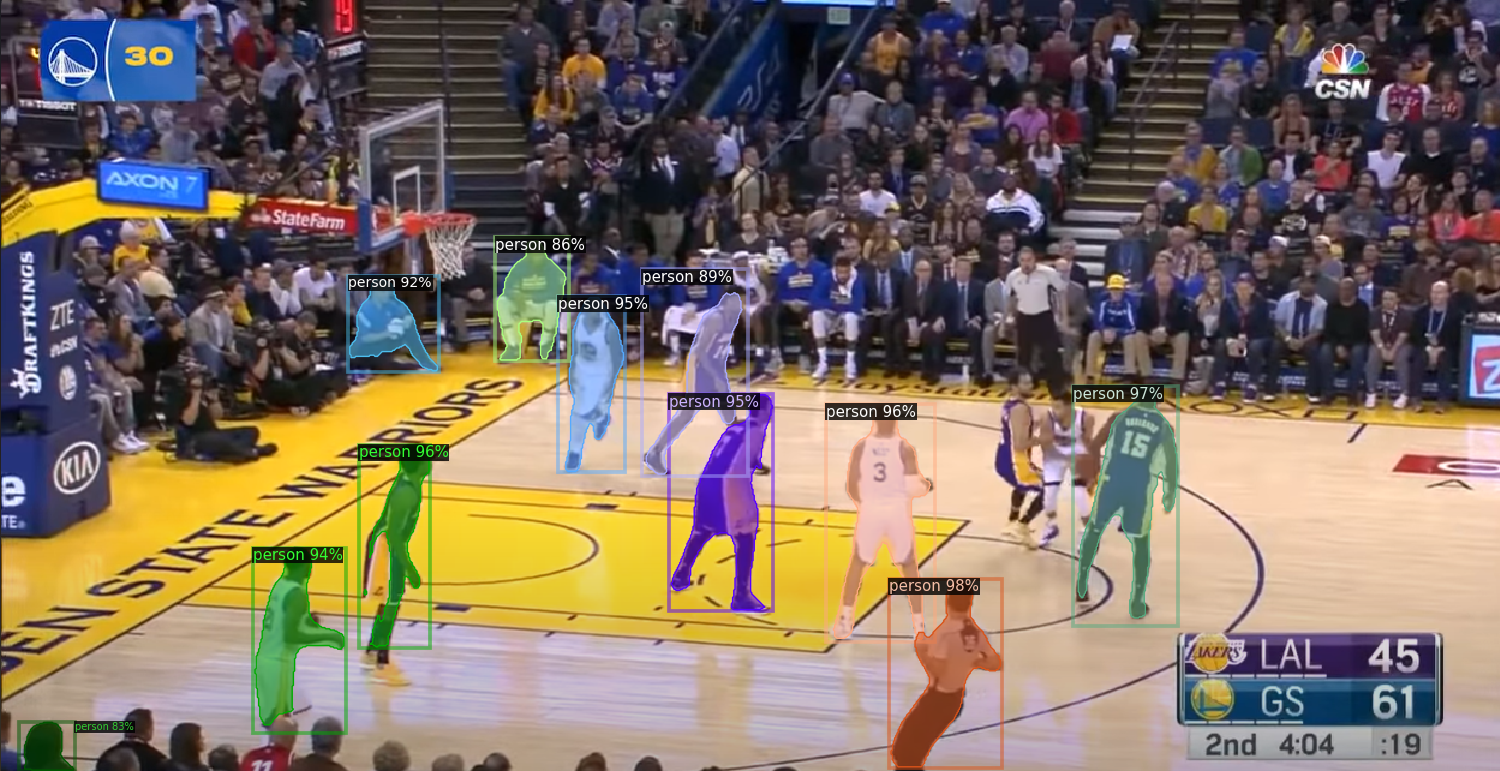

In [68]:
cfg_person = get_cfg()
cfg_person.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_person.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg_person.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
person_predictor = DefaultPredictor(cfg_person)
person_outputs = person_predictor(decision_point_image)

person_visualizer = Visualizer(decision_point_image[:, :, ::-1], MetadataCatalog.get(cfg_person.DATASETS.TRAIN[0]), scale=1.2)
person_output = person_visualizer.draw_instance_predictions(person_outputs["instances"].to("cpu"))
cv2_imshow(person_output.get_image()[:, :, ::-1])

[12/06 23:18:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


model_final_a6e10b.pkl: 237MB [00:01, 144MB/s]                           


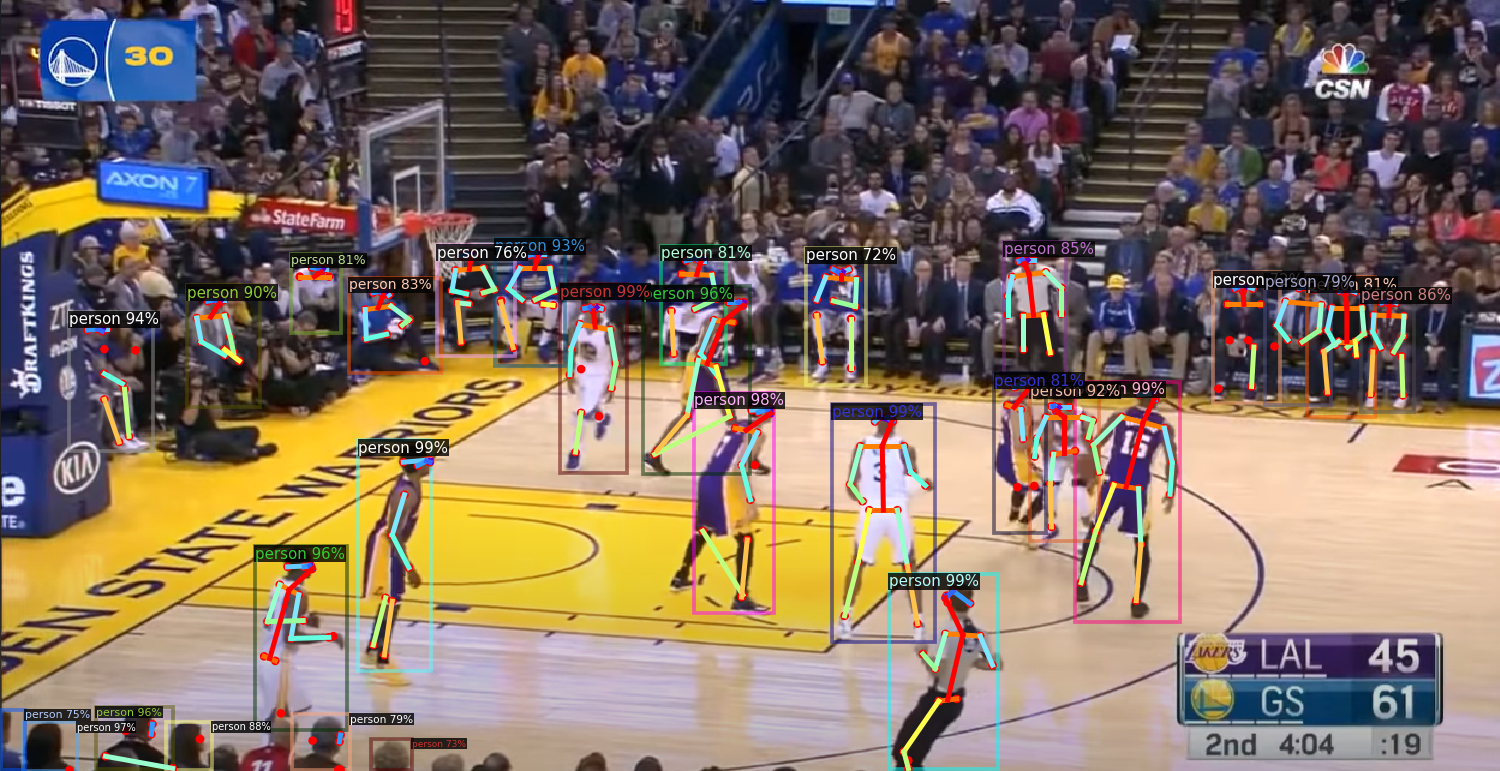

In [6]:
cfg_keypoint = get_cfg()
cfg_keypoint.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg_keypoint.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg_keypoint.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
keypoint_predictor = DefaultPredictor(cfg_keypoint)
keypoint_outputs = keypoint_predictor(decision_point_image)
keypoint_visualizer = Visualizer(decision_point_image[:,:,::-1], MetadataCatalog.get(cfg_keypoint.DATASETS.TRAIN[0]), scale=1.2)
keypoint_output = keypoint_visualizer.draw_instance_predictions(keypoint_outputs["instances"].to("cpu"))
cv2_imshow(keypoint_output.get_image()[:, :, ::-1])

In [7]:
!unzip /content/bad_nba_training_dataset.zip > /dev/null

In [8]:
register_coco_instances("nba_dataset_train", {}, "/content/bad_nba_training_dataset/train/via_region_data.json", "/content/bad_nba_training_dataset/train")

In [9]:
cfg_nba = get_cfg()
cfg_nba.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg_nba.DATASETS.TRAIN = ("nba_dataset_train")
cfg_nba.DATASETS.TEST = ()
cfg_nba.DATALOADER.NUM_WORKERS = 2
cfg_nba.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg_nba.SOLVER.IMS_PER_BATCH = 2
cfg_nba.SOLVER.BASE_LR = 0.00025
cfg_nba.SOLVER.MAX_ITER = 2000
cfg_nba.SOLVER.STEPS = []
cfg_nba.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg_nba.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg_nba.OUTPUT_DIR, exist_ok=True)
nba_trainer = DefaultTrainer(cfg_nba)
nba_trainer.resume_or_load(resume=False)
nba_trainer.train()

[12/06 23:19:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 209MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/06 23:19:19 d2.engine.train_loop]: Starting training from iteration 0
[12/06 23:19:32 d2.utils.events]:  eta: 0:17:07  iter: 19  total_loss: 2.208  loss_cls: 1.646  loss_box_reg: 0.3358  loss_rpn_cls: 0.1804  loss_rpn_loc: 0.04086    time: 0.5537  last_time: 0.4712  data_time: 0.0292  last_data_time: 0.0124   lr: 4.9953e-06  max_mem: 2870M
[12/06 23:19:47 d2.utils.events]:  eta: 0:16:24  iter: 39  total_loss: 2.139  loss_cls: 1.561  loss_box_reg: 0.3581  loss_rpn_cls: 0.1559  loss_rpn_loc: 0.04167    time: 0.5796  last_time: 0.4810  data_time: 0.0135  last_data_time: 0.0130   lr: 9.9902e-06  max_mem: 2870M
[12/06 23:19:57 d2.utils.events]:  eta: 0:15:50  iter: 59  total_loss: 1.951  loss_cls: 1.393  loss_box_reg: 0.3574  loss_rpn_cls: 0.1451  loss_rpn_loc: 0.0368    time: 0.5510  last_time: 0.4824  data_time: 0.0142  last_data_time: 0.0118   lr: 1.4985e-05  max_mem: 2870M
[12/06 23:20:07 d2.utils.events]:  eta: 0:15:45  iter: 79  total_loss: 1.729  loss_cls: 1.173  loss_box_reg: 0.

In [81]:
cfg_nba.MODEL.WEIGHTS = os.path.join(cfg_nba.OUTPUT_DIR, "model_final.pth")
cfg_nba.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
nba_predictor = DefaultPredictor(cfg_nba)

[12/07 00:59:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


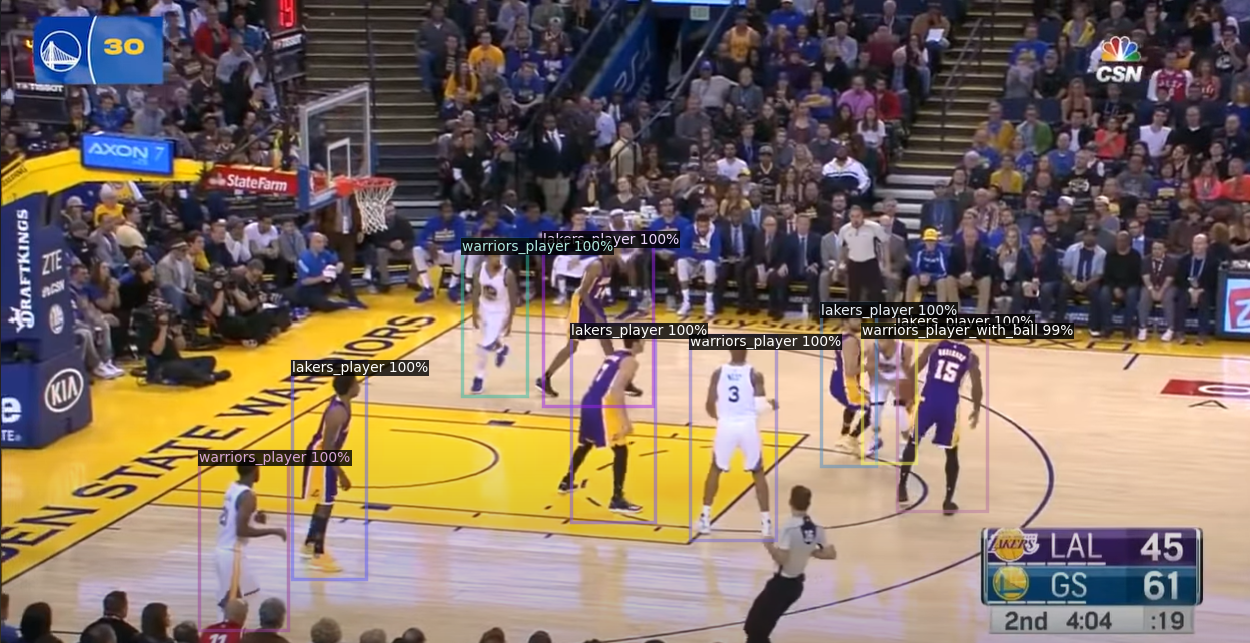

In [70]:
MetadataCatalog.get("nba_dataset_train").thing_colors = [(255, 199, 44), (0, 0, 0), (85, 37, 130), (29, 66, 138)]

nba_outputs = nba_predictor(decision_point_image)
nba_visualizer = Visualizer(
    decision_point_image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_nba.DATASETS.TRAIN),
    instance_mode=ColorMode.SEGMENTATION
)
nba_output = nba_visualizer.draw_instance_predictions(nba_outputs["instances"].to("cpu"))
cv2_imshow(nba_output.get_image()[:, :, ::-1])

In [93]:
# this code will generate and download a video version of the above, not necessary to see BRIAR in action, feel free to skip
video_capture = cv2.VideoCapture('/content/initial_play_cropped.mp4')
width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video_capture.get(cv2.CAP_PROP_FPS)
num_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

video_writer = cv2.VideoWriter('output.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

v = VideoVisualizer(MetadataCatalog.get(cfg_nba.DATASETS.TRAIN), ColorMode.IMAGE)


def runOnVideo(video):
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        visualization = v.draw_instance_predictions(frame, nba_predictor(frame)["instances"].to("cpu"))
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield visualization


for visualization in tqdm.tqdm(runOnVideo(video_capture), total=num_frames):
    video_writer.write(visualization)


video_capture.release()
video_writer.release()
cv2.destroyAllWindows()

100%|██████████| 187/187 [01:10<00:00,  2.64it/s]


In [94]:
files.download('output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
class PlayerState(Enum):
    WIDE_OPEN = 0
    MODERATELY_GUARDED = 1
    WELL_GUARDED = 2
    TRIPLE_TEAMED = 3
    QUADRUPLE_TEAMED = 4
    QUINTUPLE_TEAMED = 5


class NBAStill:
    def __init__(self, still_path):
        self.still_path = still_path
        self.players = nba_outputs["instances"]
        self.class_catalog = MetadataCatalog.get(cfg_nba.DATASETS.TRAIN).thing_classes
        self.player_with_ball = None
        self.opponent_players = []
        self.player_with_ball_team = "warriors"
        self.opponent_team = "lakers"
        self.proximity_threshold = 50

    def get_players_from_image(self):
        return nba_predictor(cv2.imread(self.still_path))

    def get_number_of_close_players(self):
        for index, coordinates in enumerate(self.players.pred_boxes):
            class_index = self.players.pred_classes[index]
            class_name = self.class_catalog[class_index]

            if class_name == f"{self.opponent_team}_player":
                self.opponent_players.append(self.players.pred_boxes[index].get_centers())

            if class_name == f"{self.player_with_ball_team}_player_with_ball":
                self.player_with_ball = self.players.pred_boxes[index].get_centers()

        player_with_ball_numpy = self.player_with_ball.cpu().numpy()[0]
        player_with_ball_x = player_with_ball_numpy[0]
        player_with_ball_y = player_with_ball_numpy[1]

        close_opponent_players = 0

        for opponent_player in self.opponent_players:
            opponent_player_numpy = opponent_player.cpu().numpy()[0]
            opponent_player_x = opponent_player_numpy[0]
            opponent_player_y = opponent_player_numpy[1]

            distance_to_player_with_the_ball = math.dist(
            [player_with_ball_x, player_with_ball_y],
            [opponent_player_x, opponent_player_y]
            )

            if distance_to_player_with_the_ball < self.proximity_threshold:
                close_opponent_players += 1

        return close_opponent_players

    def get_player_state(self):
        return PlayerState(self.get_number_of_close_players())

In [33]:
CONFIG_CODEX_MODEL = "gpt-3.5-turbo"

client = OpenAI(
  api_key=OPEN_AI_API_KEY
)

prompt_file = "/content/briar_chat_api.prompt"

@backoff.on_exception(backoff.expo, Exception, max_tries=10)
def codex_helper(extended_prompt):
    if not isinstance(extended_prompt, list):
        extended_prompt = [extended_prompt]

    responses = [
        client.chat.completions.create(
            model=CONFIG_CODEX_MODEL,
            messages=[
                {"role": "system", "content": "Only answer with a function starting def execute_command."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.,
            max_tokens=512,
            top_p = 1.,
            frequency_penalty=0,
            presence_penalty=0,
            stop=["\n\n"],
        )
        for prompt in extended_prompt
    ]

    return [responses[0].choices[0].message.content]


class CodexModel:
    max_batch_size = 5

    def __init__(self):
        with open(prompt_file) as f:
            self.base_prompt = f.read().strip()
        self.fixed_code = None

    def forward(self, prompt, input_type='image', prompt_file=None, base_prompt=None):
        if prompt_file is not None and base_prompt is None:
            with open(prompt_file) as f:
                base_prompt = f.read().strip()
        elif base_prompt is None:
            base_prompt = self.base_prompt

        if isinstance(prompt, list):
            extended_prompt = [base_prompt.replace("INSERT_QUERY_HERE", p).replace('INSERT_TYPE_HERE', input_type)
                               for p in prompt]
        elif isinstance(prompt, str):
            extended_prompt = [base_prompt.replace("INSERT_QUERY_HERE", prompt).replace('INSERT_TYPE_HERE', input_type)]
        else:
            raise TypeError("Prompt must be a string or a list of strings")

        result = self.forward_(extended_prompt)
        if not isinstance(prompt, list):
            result = result[0]

        return result

    def forward_(self, extended_prompt):
        if len(extended_prompt) > self.max_batch_size:
            response = []
            for i in range(0, len(extended_prompt), self.max_batch_size):
                response += self.forward_(extended_prompt[i:i + self.max_batch_size])
        try:
            response = codex_helper(extended_prompt)
        except Exception as e:
            print("Retrying Codex - is this rate limited??")
            print(e)
            response = self.forward_(extended_prompt)
        return response

def get_code(query):
    return CodexModel().forward(prompt=query, input_type="image")

def pretty_print_code(code):
    print("Autogenerated code snippet:\n")
    console = Console()
    syntax = Syntax(ast.unparse(ast.parse(code)), "python", theme="monokai", line_numbers=True, start_line=0)
    console.print(syntax)
    console.print(" ")

def answer_query(query_text, image, print_raw_code=False):
    code = get_code(query_text)
    if print_raw_code:
        pretty_print_code(code)

    exec(compile(code, 'Codex', 'exec'), globals())
    return execute_command(image)

def print_query_and_answer(query, answer):
    print(f"{query}\n\u001B[5;30;42m{answer}\u001B[0m")

In [89]:
query = "How many players are closely guarding the player with the ball?"

answer = answer_query(query, image="/content/initial_decision_point.png", print_raw_code=True)
print_query_and_answer(query, answer)

Autogenerated code snippet:


  0 def execute_command(still_path):                                                                               
  1     nba_still = NBAStill(still_path)                                                                           
  2     num_guarding_players = nba_still.get_number_of_close_players()                                             
  3     return num_guarding_players                                                                                

How many players are closely guarding the player with the ball?
1


In [51]:
query = "What should the player with the ball do?"

answer = answer_query(query, image="/content/initial_decision_point.png", print_raw_code=True)
print_query_and_answer(query, answer)

Autogenerated code snippet:


   0 def execute_command(still_path):                                                                              
   1     nba_still = NBAStill(still_path)                                                                          
   2     state = nba_still.get_player_state()                                                                      
   3     if state == PlayerState.WIDE_OPEN:                                                                        
   4         return 'shoot'                                                                                        
   5     elif state == PlayerState.MODERATELY_GUARDED:                                                             
   6         return 'pass'                                                                                         
   7     elif state == PlayerState.WELL_GUARDED:                                                                   
   8         return 'dribble'                                                                                      
   9     elif state == PlayerState.TRIPLE_TEAMED:                                                                  
  10         return 'look for a teammate'                                                                          
  11     elif state == PlayerState.QUADRUPLE_TEAMED:                                                               
  12         return 'protect the ball'                                                                             
  13     elif state == PlayerState.QUINTUPLE_TEAMED:                                                               
  14         return 'call for a timeout'                                                                           
  15     else:                                                                                                     
  16         return 'unknown action'                                                                               

What should the player with the ball do?
pass


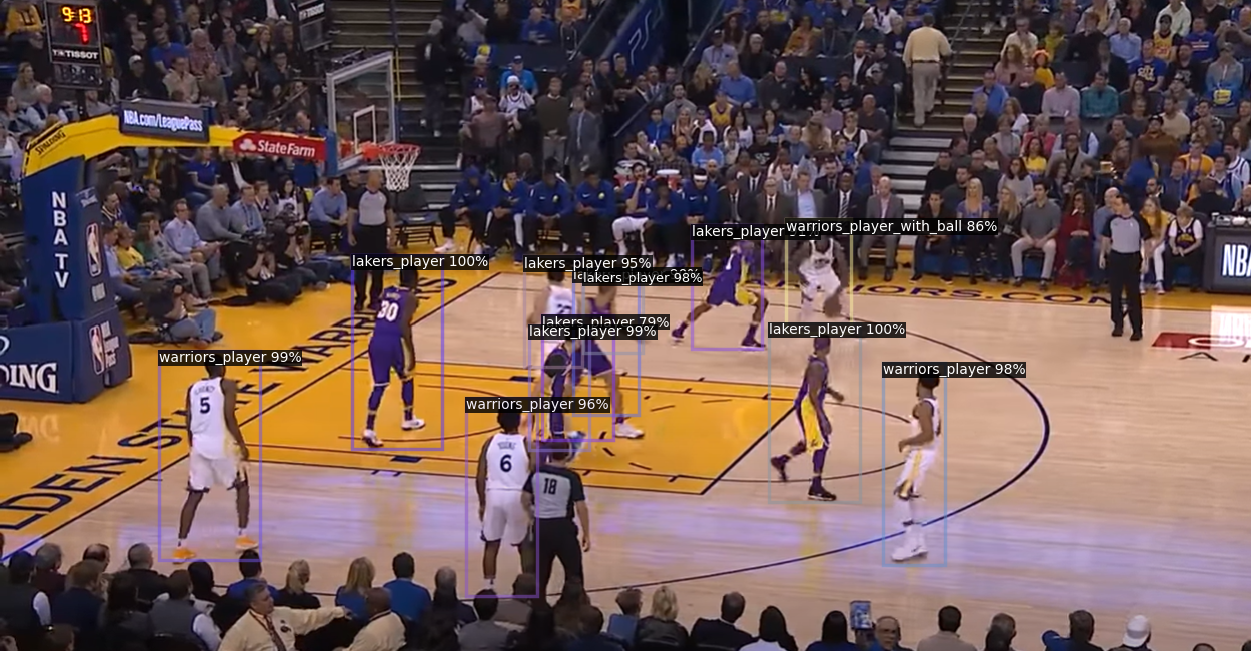

In [83]:
# Feel free to include your own images, see what the output is!

another_decision_point_image = cv2.imread("/content/another_decision_point.png")

nba_outputs = nba_predictor(another_decision_point_image)
nba_visualizer = Visualizer(
    another_decision_point_image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_nba.DATASETS.TRAIN),
    instance_mode=ColorMode.SEGMENTATION
)
nba_output = nba_visualizer.draw_instance_predictions(nba_outputs["instances"].to("cpu"))
cv2_imshow(nba_output.get_image()[:, :, ::-1])

In [84]:
query = "What should the player with the ball do?"

answer = answer_query(query, image="/content/another_decision_point.png")
print_query_and_answer(query, answer)

What should the player with the ball do?
shoot
